In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics.pairwise import pairwise_distances
import pickle
import faiss
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator as rdGen
from rdkit import DataStructs

# Building vector database

In [3]:
with open("embedding/embedding.pkl", "rb") as file:
    embedding_list = pickle.load(file)
    
embedding_list = np.nan_to_num(embedding_list)
embedding_list.shape

(10381, 512)

In [5]:
vector_dimension = embedding_list.shape[1]
index = faiss.IndexFlatL2(vector_dimension)
# index = faiss.IndexFlat(vector_dimension, faiss.METRIC_Canberra)  # One can chose a different metric
index.add(embedding_list)
print(f"Added {index.ntotal} compounds")

Added 10381 compounds


# Similarity search

## Comparing results with Tanimoto similarity scores

In [79]:
def get_fingerprints(smiles_list):
    fpgen = rdGen.GetMorganGenerator(radius=2, fpSize=2048)
    fingerprint_list = np.array([fpgen.GetFingerprint(Chem.MolFromSmiles(smiles)) for smiles in smiles_list], dtype=rdkit.DataStructs.cDataStructs.ExplicitBitVect)
    return fingerprint_list

smiles_list = np.genfromtxt("data/smiles.txt", dtype=str, delimiter='\n', comments=None)
fingerprint_list = get_fingerprints(smiles_list)
fingerprint_list.shape

(10381, 2048)

In [8]:
''' Get the closest neighbours based on embedding and Morgan fingerprints '''
def get_query_results(smiles, embedding):
    query = np.array([embedding])
    distances, indices = index.search(query, k=index.ntotal)
    embedding_results = pd.DataFrame({"distance": distances[0], "index": indices[0]})
    fpgen = rdGen.GetMorganGenerator(radius=2, fpSize=2048)
    query_fp = fpgen.GetFingerprint(Chem.MolFromSmiles(smiles))
    similarities = [DataStructs.TanimotoSimilarity(fpgen.GetFingerprint(Chem.MolFromSmiles(smi)), query_fp) for smi in smiles_list]
    similarities = np.array(similarities)
    similarity_results = pd.DataFrame({
        "similarity": -np.sort(-similarities),
        "index": np.argsort(-similarities)
    })
    return embedding_results, similarity_results

''' Get data about n closest neighbours based on Morgan fingerprints '''
def get_data(embedding_results, similarity_results, n):
    index_list = embedding_results[["index"]].to_numpy().flatten()
    distance_list = embedding_results[["distance"]].to_numpy().flatten()
    similarity_list = similarity_results[["similarity"]].to_numpy().flatten()
    similarity_index_list = similarity_results[["index"]].to_numpy().flatten()

    emb_rank_dict = dict(zip(index_list, list(range(len(index_list)))))
    distance_dict = dict(zip(index_list, distance_list))
    emb_rank = []
    distance = []
    for index_s in similarity_index_list:
        if index_s in emb_rank_dict:
            emb_rank.append(emb_rank_dict[index_s])
            distance.append(distance_dict[index_s])
        else:
            emb_rank.append(-2)
            distance.append(-1)
    data = {
        "rank": list(range(n)),
        "emb_rank": emb_rank,
        "index": similarity_index_list[:n],
        "smiles": list(smiles_list[similarity_index_list[:n]]),
        "similarity": list(similarity_list[:n]),
        "distance": distance
    }
    return data

''' Get data about embedding neighbours that are not in n closest for Morgan fingerprints '''
def get_remaining_data(embedding_results, similarity_results, n):
    similarity_list = similarity_results[["similarity"]].to_numpy().flatten()
    similarity_index_list = similarity_results[["index"]].to_numpy().flatten()
    index_list = embedding_results[["index"]].to_numpy().flatten()[:n]
    emb_rank = list(range(n))
    emb_rank = list(filter(lambda x: index_list[x] not in similarity_index_list[:n], emb_rank))
    index_list = list(index_list[emb_rank])
    distance = embedding_results[["distance"]].to_numpy().flatten()
    distance = list(distance[emb_rank])
    
    data = {
        "emb_rank": emb_rank,
        "index": index_list,
        "smiles": list(smiles_list[index_list]),
        "similarity": list(similarity_list[index_list]),
        "distance": distance
    }
    return data

''' Display the summary of closest neighbours based on embedding and Morgan fingerprints '''
def generate_summary(smiles, embedding, n=10):
    embedding_results, similarity_results = get_query_results(smiles, embedding)
    total_rows = 2 * n + 1
    fig = plt.figure(figsize=(8, (total_rows * 2)))
    gs = GridSpec(total_rows, 1, figure=fig, hspace=0.0)

    # ------------------------ First plot ------------------------
    data = get_data(embedding_results, similarity_results, n)
    mols = [Chem.MolFromSmiles(smiles) for smiles in data["smiles"]]
    for i, mol in enumerate(mols):
        ax = fig.add_subplot(gs[i, 0])
        img = Draw.MolToImage(mol, size=(150, 150))
        ax.imshow(img)
        ax.axis("off")
        
        color = 'black' if data['emb_rank'][i] < 10 else 'red'
        text = (f"Rank: {data['rank'][i]+1}   Embedding rank: {data['emb_rank'][i]+1}\n"
                f"Index: {data['index'][i]}\n"
                f"SMILES: {data['smiles'][i]}\n"
                f"Similarity: {round(data['similarity'][i], 3)}\n"
                f"Distance: {round(data['distance'][i], 3)}")
        ax.text(160, 75, text, fontsize=10, verticalalignment='center', color=color)

    # ------------------------ Separator ------------------------
    separator_row = n
    ax_sep = fig.add_subplot(gs[separator_row, 0])
    ax_sep.axis('off')
    ax_sep.text(0.8, 0.5, '----------------------- Not Tanimoto similar --------------------',
                horizontalalignment='center', verticalalignment='center',
                fontsize=12)

    # ------------------------ Second plot ------------------------
    data = get_remaining_data(embedding_results, similarity_results, n)
    mols = [Chem.MolFromSmiles(smiles) for smiles in data["smiles"]]
    for i, mol in enumerate(mols):
        ax = fig.add_subplot(gs[n + 1 + i, 0])
        img = Draw.MolToImage(mol, size=(150, 150))
        ax.imshow(img)
        ax.axis("off")

        text = (f"Embedding rank: {data['emb_rank'][i]+1}\n"
                f"Index: {data['index'][i]}\n"
                f"SMILES: {data['smiles'][i]}\n"
                f"Similarity: {round(data['similarity'][i], 3)}\n"
                f"Distance: {round(data['distance'][i], 3)}")
        ax.text(160, 75, text, fontsize=10, verticalalignment='center')

    plt.tight_layout()
    plt.show()

Generate the summary for a compound from the query dataset

In [ ]:
query_smiles_list = np.genfromtxt("query_smiles.txt", dtype=str, delimiter='\n', comments=None)
print(f"Loaded {len(query_smiles_list)} SMILES")

with open("query_embedding.pkl", "rb") as file:
    query_embedding_list = pickle.load(file)
print(f"Loaded {len(query_embedding_list)} embeddings")

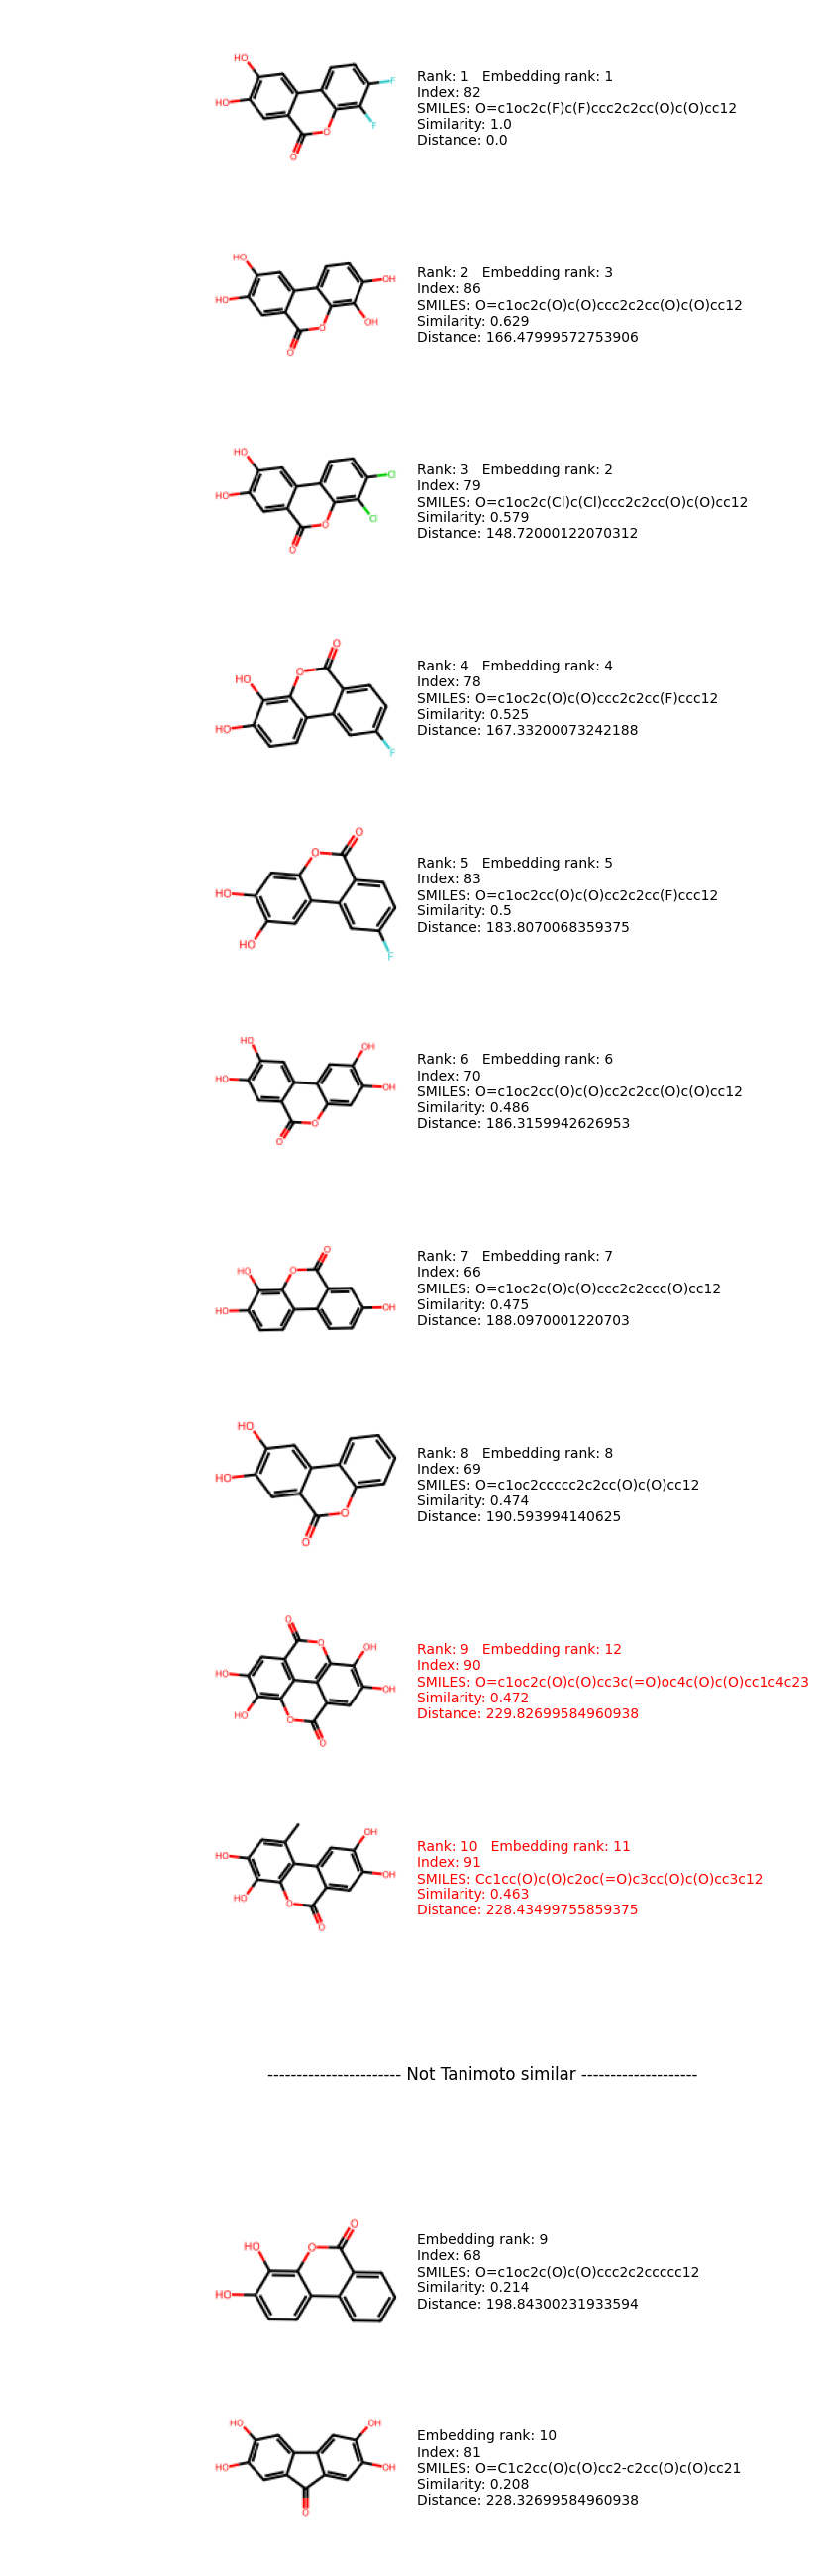

In [137]:
idx = 82
smiles, embedding = query_smiles_list[idx], query_embedding_list[idx]
generate_summary(smiles, embedding)

# Clustering compounds based on embedding

In [ ]:
n_clusters = 500
kmeans = faiss.Kmeans(d=vector_dimension, k=n_clusters, niter=20, verbose=True)
kmeans.train(embedding_list)

distances, indices = kmeans.index.search(embedding_list, 1)

cluster_indices = {i: [] for i in range(n_clusters)}
for idx, cluster_id in enumerate(indices):
    cluster_indices[cluster_id[0]].append(idx)

## Calculate mean Tanimoto similarity in clusters

Calculate pairwise Tanimoto similarity for Morgan fingerprints. Load the similarity matrix from file or generated it.

In [20]:
def get_fingerprints(smiles_list):
    fpgen = rdGen.GetMorganGenerator(radius=2, fpSize=2048)
    fingerprint_list = np.array([fpgen.GetFingerprint(Chem.MolFromSmiles(smiles)) for smiles in smiles_list], dtype=rdkit.DataStructs.cDataStructs.ExplicitBitVect)
    return fingerprint_list

def get_pairwise_similarity(smiles_list):    
    fingerprint_list = get_fingerprints(smiles_list)
    similarity_matrix = 1 - pairwise_distances(X = fingerprint_list, metric='jaccard', n_jobs = -1)
    return similarity_matrix

In [23]:
# Load similarity matrix for compounds in the database
with open("similarity.pkl", "rb") as file:
    similarity_matrix = pickle.load(file)

# or generate it
# smiles_list = np.genfromtxt("smiles.txt", dtype=str, comments=None)
# similarity_matrix = get_pairwise_similarity(smiles_list)

In [19]:
similarity_total = 0
count_total = 0
for cluster_id, indices in cluster_indices.items():
    n = len(indices)
    similarity = 0
    count = 0
    
    for i in range(n):
        for j in range(i+1, n):
            similarity += similarity_matrix[i][j]
            count += 1
    if count == 0:
        count = 1
        similarity = 1.0

    similarity_total += similarity
    count_total += count
print(f"Mean similarity in cluster: {round(similarity_total / count_total, 3)}")

Mean similarity in cluster: 0.328
